# Face Generative Adversial Network 

Challenge_1: Use the CelebA dataset to generate realistic faces using a DCGAN <br>
Challenge_2: Understand and extract the internal structure of the faces to create customizable and unique faces<br>
Challenge_3: Face interpolation

Tip: Train the network with low res first and the increase resolution 

In [88]:
# load libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os 

# device gpu device
device = torch.device("cuda") 

data_dir = "data/img_align_celeba/"

image_list = [os.path.join(data_dir, i)
              for i in os.listdir(data_dir)]

First let's explore the image dataset

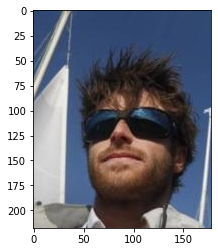

In [89]:
image = cv2.imread(image_list[3])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [90]:
image.shape

(218, 178, 3)

### Create Dataset

In [91]:
imsize = 64

transform = transforms.Compose(
    [transforms.Resize(imsize),
     transforms.CenterCrop(imsize),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize between [-1 1]


dataset = torchvision.datasets.ImageFolder(root="data/",
                           transform=transform)

batch_size = 32

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2,
                                         pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


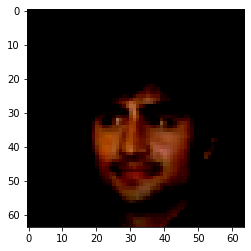

In [92]:
# visualize image from dataset
dataiter = iter(dataloader)
d, l = dataiter.next()
plt.imshow(np.transpose(d[2], (1, 2, 0)))
plt.show()

### Define Architecture

In [93]:
# auxiliar layers 
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class UnFlatten(nn.Module):
    
    def __init__(self, channels, sx, sy):
        super(UnFlatten, self).__init__()
        self.channels = channels
        self.sx = sx
        self.sy = sy
    
    def forward(self, input):
        return input.view(input.size(0), self.channels, 
                          self.sx, self.sy)

In [94]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(
            # in_filters, out_filters, kernel, stride, padding
            nn.Conv2d(3,  64, 4, 2, 1), # conv1 64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, # conv2 I=32x32 
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, # conv3 I=16x16
                      stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=4, # conv4 O=2x2
                      stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, # conv5 
                      stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True), # conv6
            nn.Conv2d(512, 1, 4, 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.net(input)

In [95]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, #conv1
                               stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, #conv2
                               stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, kernel_size=4, #conv3
                               stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, #conv4
                               stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64,kernel_size=4,#conv5
                               stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4,#conv6
                               stride=2, padding=1),
            nn.Tanh()
            
            )
    def forward(self, input):
        return self.net(input)

### Train Model

In [96]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

n_epochs = 100

criterion = nn.BCELoss()

dis_learning_rate = 0.0002
gen_learning_rate = 0.0002
dis_optimizer = optim.Adam(discriminator.parameters(),
                           dis_learning_rate, betas=(0.5, 0.999))
gen_optimizer = optim.Adam(generator.parameters(),
                           dis_learning_rate, betas=(0.5, 0.999))

# trues and fake values 

# keep track of progress
G_losses = []
D_losses = []

for epoch in range(n_epochs):
    
    for i, data in enumerate(dataloader, 0): 
        # load image batch
        image, _ = data
        image = image.to(device)
        batch_size = image.size()[0]
        trues = torch.ones([batch_size, 1], device=device)
        fakes = torch.zeros([batch_size, 1], device=device)
        
        # zero grads
        dis_optimizer.zero_grad()
        
        
        # TRAIN DISCRIMINATIVE
        # true batch
        out = discriminator(image).view(-1, 1)
        loss_real = criterion(out, trues)
        loss_real.backward(retain_graph=True)
        # fake batch
        noise = torch.randn(batch_size, 100, 1, 1, device=device)

        fake = generator(noise)
        out = discriminator(fake).view(-1, 1)
        loss_fake = criterion(out, fakes)
        loss_fake.backward(retain_graph=True)
        lossD = loss_real + loss_fake
        dis_optimizer.step()
        
        # TRAIN GENERATOR
        # zero grads
        gen_optimizer.zero_grad()
        
        out = discriminator(fake).view(-1, 1)
        lossG = criterion(out, trues)
        lossG.backward()
        gen_optimizer.step()
        if i % 100 == 0:
            torch.save(discriminator.state_dict(), "models/discriminator_state.pt")
            torch.save(generator.state_dict(), "models/generator_state.pt")
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, n_epochs, i, len(dataloader),
                     lossD.item(), lossG.item()))
        
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
        

[0/100][0/6332]	Loss_D: 1.4050	Loss_G: 2.2733	
[0/100][100/6332]	Loss_D: 0.0854	Loss_G: 6.1573	
[0/100][200/6332]	Loss_D: 0.1164	Loss_G: 5.3810	
[0/100][300/6332]	Loss_D: 0.0423	Loss_G: 4.4540	
[0/100][400/6332]	Loss_D: 0.0692	Loss_G: 3.7621	
[0/100][500/6332]	Loss_D: 0.4087	Loss_G: 2.7129	
[0/100][600/6332]	Loss_D: 1.7692	Loss_G: 1.9726	
[0/100][700/6332]	Loss_D: 0.4598	Loss_G: 3.3167	
[0/100][800/6332]	Loss_D: 0.2997	Loss_G: 2.3732	
[0/100][900/6332]	Loss_D: 2.0406	Loss_G: 2.7578	
[0/100][1000/6332]	Loss_D: 1.3387	Loss_G: 3.9310	
[0/100][1100/6332]	Loss_D: 0.6853	Loss_G: 5.2755	
[0/100][1200/6332]	Loss_D: 0.6655	Loss_G: 4.6111	
[0/100][1300/6332]	Loss_D: 0.4793	Loss_G: 3.5984	
[0/100][1400/6332]	Loss_D: 0.5493	Loss_G: 4.6380	
[0/100][1500/6332]	Loss_D: 1.0806	Loss_G: 4.1344	
[0/100][1600/6332]	Loss_D: 0.7921	Loss_G: 6.8698	
[0/100][1700/6332]	Loss_D: 0.3795	Loss_G: 3.7859	
[0/100][1800/6332]	Loss_D: 0.3135	Loss_G: 3.5972	
[0/100][1900/6332]	Loss_D: 0.4247	Loss_G: 4.6338	
[0/100][2000

[2/100][3700/6332]	Loss_D: 0.2169	Loss_G: 5.1564	
[2/100][3800/6332]	Loss_D: 0.0669	Loss_G: 5.0006	
[2/100][3900/6332]	Loss_D: 0.0274	Loss_G: 5.2750	
[2/100][4000/6332]	Loss_D: 0.2365	Loss_G: 4.7923	
[2/100][4100/6332]	Loss_D: 0.1693	Loss_G: 3.7663	
[2/100][4200/6332]	Loss_D: 0.3470	Loss_G: 3.3802	
[2/100][4300/6332]	Loss_D: 0.2488	Loss_G: 5.8820	
[2/100][4400/6332]	Loss_D: 0.0839	Loss_G: 4.4002	
[2/100][4500/6332]	Loss_D: 0.1035	Loss_G: 2.7566	
[2/100][4600/6332]	Loss_D: 0.3635	Loss_G: 7.8662	
[2/100][4700/6332]	Loss_D: 0.1585	Loss_G: 7.0581	
[2/100][4800/6332]	Loss_D: 1.0568	Loss_G: 4.9199	
[2/100][4900/6332]	Loss_D: 0.1461	Loss_G: 5.7069	
[2/100][5000/6332]	Loss_D: 0.2151	Loss_G: 5.2408	
[2/100][5100/6332]	Loss_D: 0.2331	Loss_G: 4.1926	
[2/100][5200/6332]	Loss_D: 0.1269	Loss_G: 4.6489	
[2/100][5300/6332]	Loss_D: 0.1076	Loss_G: 4.3570	
[2/100][5400/6332]	Loss_D: 0.2023	Loss_G: 6.0991	
[2/100][5500/6332]	Loss_D: 0.0575	Loss_G: 6.2159	
[2/100][5600/6332]	Loss_D: 0.0589	Loss_G: 5.4012	


Exception in thread Thread-23:
Traceback (most recent call last):
  File "/usr/lib64/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib64/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pol/Documents/ml/env3.7/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 21, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib64/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/pol/Documents/ml/env3.7/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 284, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib64/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib64/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.c

KeyboardInterrupt: 

### Analysis

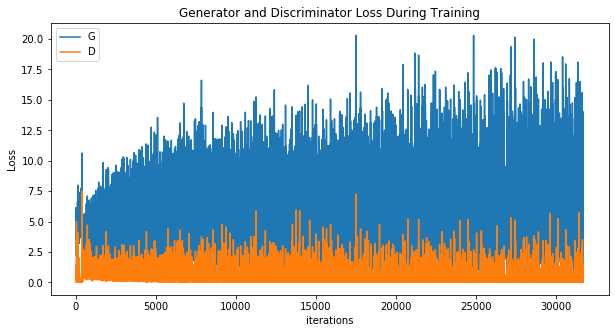

In [97]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [98]:
noise = torch.randn(batch_size, 100,1, 1, device=device)
img = generator(noise)

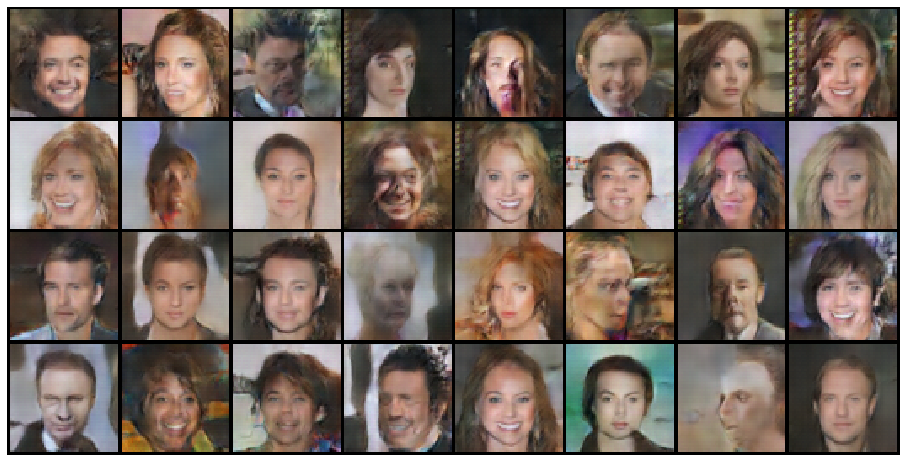

In [107]:
fig = plt.figure(figsize=(16,16))
plt.axis("off")
img_list = [vutils.make_grid(img, padding=2, normalize=True).cpu().detach()]

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
plt.show()

In [166]:
# vector woman
images = []
vec_woman = noise[1].view(-1, 100, 1, 1)
vec_man = noise[2].view(-1, 100, 1, 1)
vec_woman = vec_woman 
woman = generator(vec_woman)
man = generator(vec_man)
images.append(vutils.make_grid(woman, padding=2, normalize=True).cpu().detach())
images.append(vutils.make_grid(woman, padding=2, normalize=True).cpu().detach())

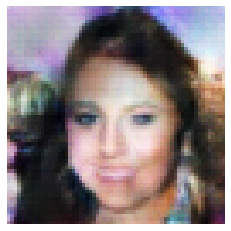

In [169]:

plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in images]
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


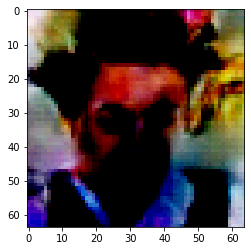

In [153]:
plt.imshow(np.transpose(man[0].cpu().detach(),(1,2,0)))
plt.show()